# Сборный проект 2

## Введение

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Существует две задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [23]:
!pip install -q phik


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', -1)
from sklearn.svm import SVC
matplotlib_axes_logger.setLevel('ERROR')
RANDOM_STATE = 42
TEST_SIZE = 0.25
sns.set()

In [25]:
df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
display(df_train_job_satisfaction_rate.head(5))
df_train_job_satisfaction_rate.info()

df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
display(df_test_features.head(5))
df_test_features.info()

df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
display(df_test_target_job_satisfaction_rate.head(5))
df_test_target_job_satisfaction_rate.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


### Предобработка данных

Произведена проверка на дубликаты по столбцу id для всех трех датафреймов - дубликатов нет

In [26]:
print(f'Количество дубликтов: df_train_job_satisfaction_rate: {df_train_job_satisfaction_rate.duplicated(subset="id").sum()},'
      f'df_test_features: {df_test_features.duplicated(subset="id").sum()},'
      f'df_test_target_job_satisfaction_rate: {df_test_target_job_satisfaction_rate.duplicated(subset="id").sum()}')


Количество дубликтов: df_train_job_satisfaction_rate: 0,df_test_features: 0,df_test_target_job_satisfaction_rate: 0


В датафреймах df_train_job_satisfaction_rate и df_test_features обнаружены NULL значения для колонок:
- dept
- level

Так как это категориальные переменные, то сначала надо произвести вывод всех значений которе принимает каждый параметр

In [27]:
display(df_train_job_satisfaction_rate['dept'].value_counts(dropna = False))
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))

display(df_test_features['dept'].value_counts(dropna = False))
display(df_test_features['level'].value_counts(dropna = False))


sales         1512
technology    866 
purchasing    610 
marketing     550 
hr            456 
NaN           6   
Name: dept, dtype: int64

junior    1894
middle    1744
sinior    358 
NaN       4   
Name: level, dtype: int64

sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN           2  
              1  
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
NaN       1  
Name: level, dtype: int64

Так как количество строкс с NaN для этих параметров крайне мало по сравнению с общим количеством строк и нет явного значения, на которое можно заменить NaN (так как это категориальные параметры) то я предлагаю строки с NaN удалить из этих датафреймов

In [28]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.dropna()
df_train_job_satisfaction_rate.info()

df_test_features = df_test_features.dropna()
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   object 
 2   level                  3990 non-null   object 
 3   workload               3990 non-null   object 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   object 
 6   last_year_violations   3990 non-null   object 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 342.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----

Кроме того, надо проввалидировать значения оставшихся кат параметров

In [29]:
display(df_train_job_satisfaction_rate['workload'].value_counts())
display(df_train_job_satisfaction_rate['last_year_promo'].value_counts())
display(df_train_job_satisfaction_rate['last_year_violations'].value_counts())
display(df_test_features['workload'].value_counts())
display(df_test_features['last_year_promo'].value_counts())
display(df_test_features['last_year_violations'].value_counts())



medium    2060
low       1197
high      733 
Name: workload, dtype: int64

no     3870
yes    120 
Name: last_year_promo, dtype: int64

no     3432
yes    558 
Name: last_year_violations, dtype: int64

medium    1041
low       592 
high      363 
          1   
Name: workload, dtype: int64

no     1934
yes    63  
Name: last_year_promo, dtype: int64

no     1735
yes    262 
Name: last_year_violations, dtype: int64

С этими значениями все нормально - опечаток и ошибок при вводе нет

В значении 'sinior' для колонки level для датафреймов df_train_job_satisfaction_rate и df_test_features допущена грамматическая ошибка - но она допущена везде, где используется это значение - написано как *sinior*.  Предлагаю везде исправить на *senior*

In [30]:
df_train_job_satisfaction_rate['level'] = df_train_job_satisfaction_rate['level'].replace('sinior', 'senior')
display(df_train_job_satisfaction_rate['level'].value_counts(dropna = False))
df_test_features['level'] = df_test_features['level'].replace('sinior', 'senior')
display(df_test_features['level'].value_counts(dropna = False))

junior    1888
middle    1744
senior    358 
Name: level, dtype: int64

junior    972
middle    854
senior    171
Name: level, dtype: int64

Необходимо изменить тип "object" на "string" для всех колонок типа *object*

In [31]:
df_train_job_satisfaction_rate_str_col_list = df_train_job_satisfaction_rate.select_dtypes(exclude=np.number).columns
df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list] = \
  df_train_job_satisfaction_rate[df_train_job_satisfaction_rate_str_col_list].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features_str_col_list = df_test_features.select_dtypes(exclude=np.number).columns
df_test_features[df_test_features_str_col_list] = \
  df_test_features[df_test_features_str_col_list].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   string 
 2   level                  3990 non-null   string 
 3   workload               3990 non-null   string 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   string 
 6   last_year_violations   3990 non-null   string 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), string(5)
memory usage: 342.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

Колонки employment_years и supervisor_evaluation для test и train датафреймов надо перевести в категориальный формат, так как их значения представляют собой целые числа и они занимают отоносительно небольшой диапазон

In [32]:
df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']] = \
  df_train_job_satisfaction_rate[['employment_years', 'supervisor_evaluation']].astype('string')
df_train_job_satisfaction_rate.info()

df_test_features[['employment_years', 'supervisor_evaluation']] = \
  df_test_features[['employment_years', 'supervisor_evaluation']].astype('string')
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   string 
 2   level                  3990 non-null   string 
 3   workload               3990 non-null   string 
 4   employment_years       3990 non-null   string 
 5   last_year_promo        3990 non-null   string 
 6   last_year_violations   3990 non-null   string 
 7   supervisor_evaluation  3990 non-null   string 
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(2), string(7)
memory usage: 342.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  -----

### Исследовательский анализ данных

Построим гистограммы и boxplots для количественных параметров и pie диаграммы для категориальных

,id,salary,job_satisfaction_rate
count,3990.000000,3990.000000,3990.000000
mean,544951.793985,33953.383459,0.533772
std,257889.850721,14907.247698,0.225353
min,100954.000000,12000.000000,0.030000
25%,322834.250000,22800.000000,0.360000
50%,534082.500000,30000.000000,0.560000
75%,771600.000000,43200.000000,0.710000
max,999521.000000,98400.000000,1.000000


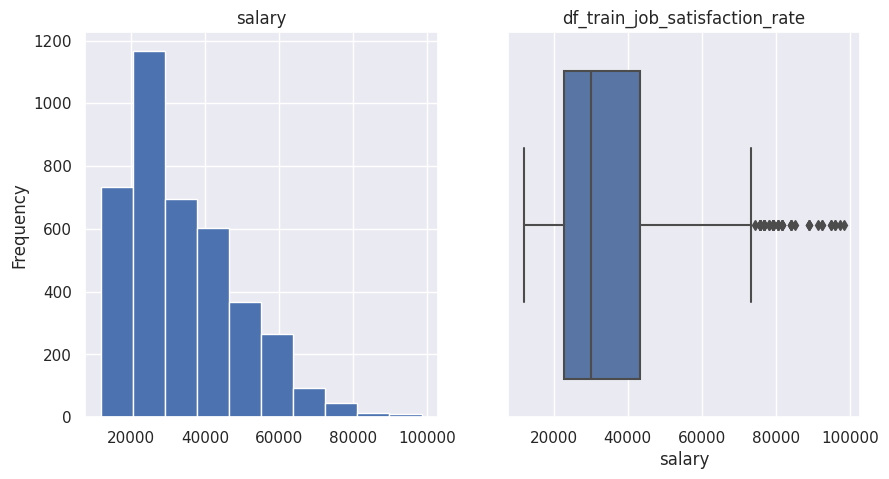

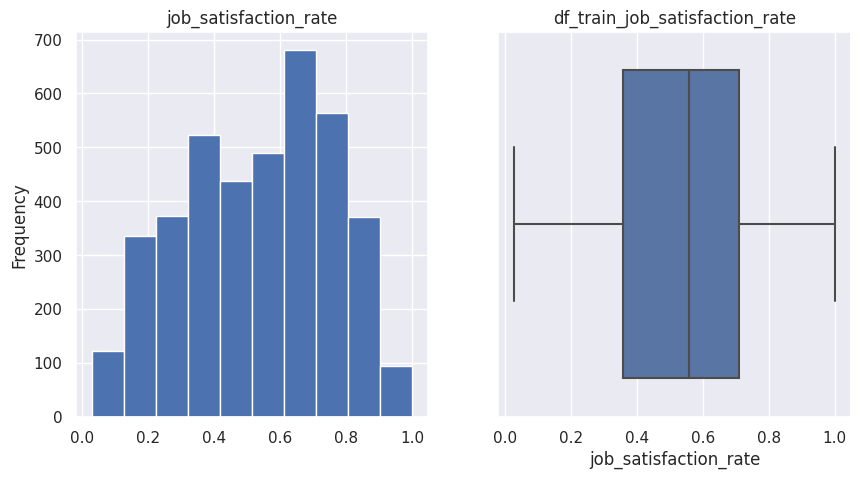

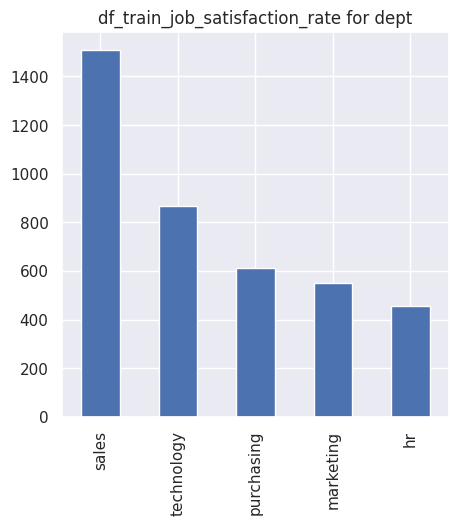

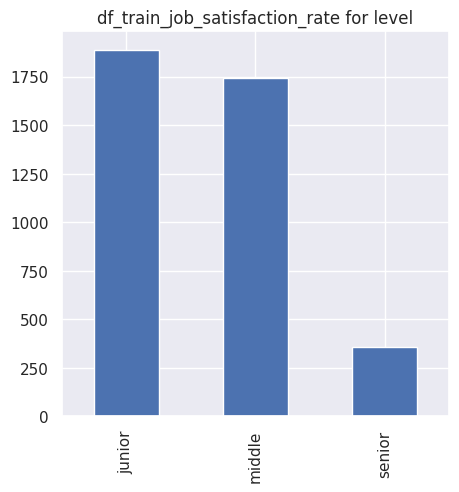

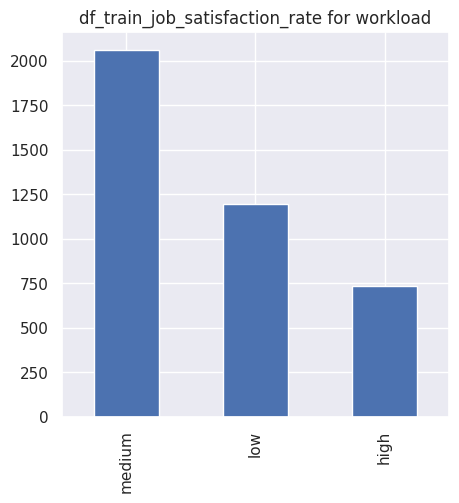

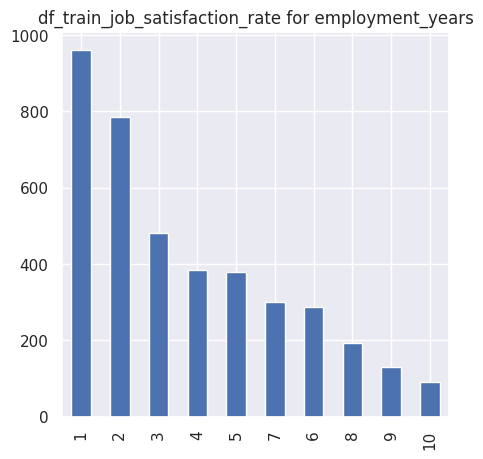

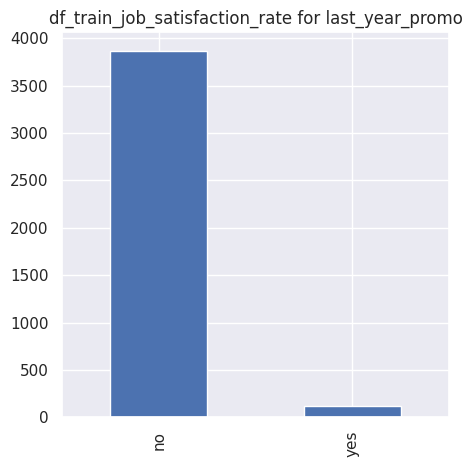

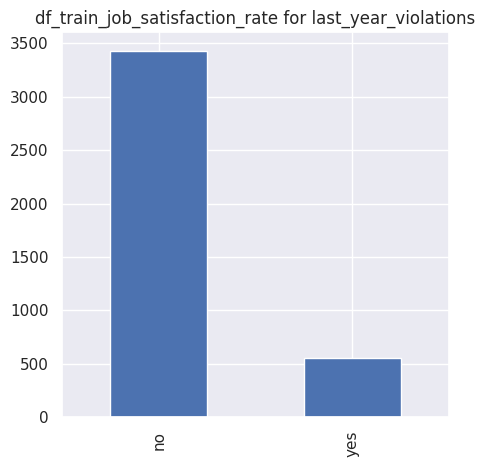

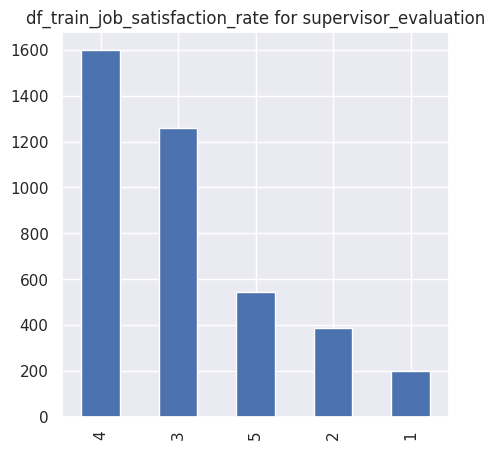

In [33]:
display(df_train_job_satisfaction_rate.describe())

def plot_sub_plot_hist_boxplot(df, title):
    for col in df.columns:
        if col == 'id':
            continue
        fig, axes = plt.subplots(nrows=1, ncols=2)
        df[col].plot(kind="hist", title=col, figsize=(10, 5), ax = axes[0])
        sns.boxplot(df[col], ax = axes[1])
        plt.title(title)
        plt.show()

def plot_pie_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

def plot_bar_plot_for_columns(df, title):
    for col in df.columns:
        df[col].value_counts().plot(kind='bar',  label='',  figsize=(5,5), title=col);
        plt.title(f'{title} for {col}')
        plt.show()

plot_sub_plot_hist_boxplot(df_train_job_satisfaction_rate.select_dtypes(include=np.number), 'df_train_job_satisfaction_rate')
plot_bar_plot_for_columns(df_train_job_satisfaction_rate.select_dtypes(exclude=np.number), 'df_train_job_satisfaction_rate')


Я не вижу явных выбросов для количественных параметров. Распределение целевой переменной job_satisfaction_rate похоже на нормальное, mean ~ median, выбросов нет.

,dept,employment_years,job_satisfaction_rate,last_year_promo,last_year_violations,level,salary,supervisor_evaluation,workload
dept,1.000000,0.035478,0.082037,0.000000,0.000000,0.000000,0.281731,0.104699,0.016556
employment_years,0.035478,1.000000,0.326829,0.183654,0.057655,0.683189,0.483064,0.000000,0.181259
job_satisfaction_rate,0.082037,0.326829,1.000000,0.190921,0.560773,0.080910,0.166577,0.764170,0.056024
last_year_promo,0.000000,0.183654,0.190921,1.000000,0.000000,0.101530,0.214741,0.013619,0.058676
last_year_violations,0.000000,0.057655,0.560773,0.000000,1.000000,0.000000,0.000000,0.182371,0.000000
level,0.000000,0.683189,0.080910,0.101530,0.000000,1.000000,0.717484,0.000000,0.419471
salary,0.281731,0.483064,0.166577,0.214741,0.000000,0.717484,1.000000,0.000000,0.788710
supervisor_evaluation,0.104699,0.000000,0.764170,0.013619,0.182371,0.000000,0.000000,1.000000,0.036178
workload,0.016556,0.181259,0.056024,0.058676,0.000000,0.419471,0.788710,0.036178,1.000000


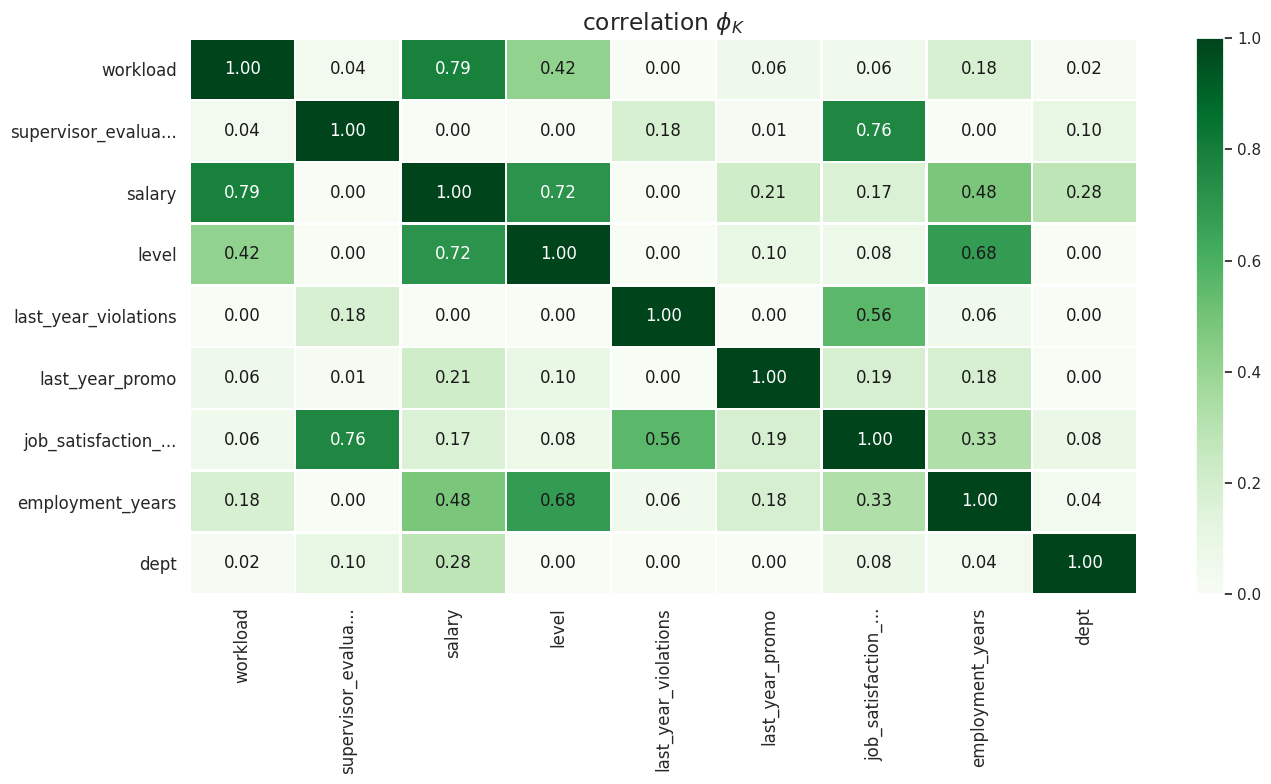

In [34]:
interval_cols = df_train_job_satisfaction_rate.select_dtypes(include=np.number).columns.difference(['id'])

#phik_overview = phik_matrix(df_market_all_active[df_market_all_active.columns.difference(['id']).difference(['Покупательская активность'])], interval_cols=list(interval_cols))
phik_overview = phik_matrix(df_train_job_satisfaction_rate[df_train_job_satisfaction_rate.columns.difference(['id'])], interval_cols=list(interval_cols))

display(phik_overview)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.2,
    figsize=(14, 8)
)


Фик матрица показала следующие корреляционные соотношения между параметрами:
- workload и salary - это объясняется тем, что большая нагрузка на сотрудника обычно сопровождается ростом его зарплаты
- salary и level - чем выше Level сотрудника тем выше его зарплата
- supervisor_evaluation и job_satisfaction_rate - чем выше оценка супервизора - тем выше его уровень удовлетворенности работой
- level и employment_years - level сотрудника зависит от количества проработанных лет

В целом корреляционная матрица не показала каких либо исключительных ситуаций - все более менее объяснимо. Есть коррелция между некоторыми входными параметрами и целевым - не не для всех входных параметров.

### Подготовка данных

### Обучение моделей

### Выводы

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

### Предобработка данных

### Исследовательский анализ данных

### Добавление нового входного признака

### Подготовка данных

### Обучение моделей

### Выводы

## Общие выводы 